In [1]:
import os
import music21 as m21
import numpy as np
import pandas as pd
import warnings
from typing import Dict, List, Optional, Sequence, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
sns.set()
warnings.filterwarnings("ignore")
from fractions import Fraction

In [2]:
dur=[0.25,0.5,0.75,1.,1.5,2.,3.,4.]

In [3]:
path = r"C:\Users\omer-\Desktop\musics"

In [4]:
def load(path):
    songs = []
    for m in os.listdir(path):
        warnings.filterwarnings("ignore")
        if m[-3:] == "MID" or m[-3:] == "mid":
            songs.append(m21.converter.parse((path+"\{}").format(m)))
    return songs

In [5]:
def dataframe(songs):
    x = []
    sizes= []
    for m in songs:
        for s in m:
            notes = [a for a in s.flat.notesAndRests]
            s = 0
            for i in notes:
                s = s+1
                if isinstance(i,m21.note.Note):
                    x.append([i.pitch.midi,float(i.duration.quarterLength)])
                else:
                    x.append([0,float(i.duration.quarterLength)])
            sizes.append(s)
    df = pd.DataFrame(x,columns=["pitch", "duration"])
    return df,sizes

In [6]:
def transpose(m):
    key = m.analyze("key")
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic,m21.pitch.Pitch("C"))
    if key.mode == "minor":
        interval = m21.interval.Interval(key.tonic,m21.pitch.Pitch("A"))
    
    return m.transpose(interval)      
        

In [7]:
def duration(m,dur):
    for note in  m.flat.notesAndRests:
        if note.duration.quarterLength not in dur:
            return False
    return True

In [8]:
def preprocess(path,dur):
    songs = load(path)
    s = []
    for m in songs:
        if not duration(m,dur):
            continue
        s.append(transpose(m))
    
    return s

In [9]:
def batch(encoded,samp_per_batch=12, seq_len=10):
    note_per_batch = samp_per_batch * seq_len
    num_batches_avail = int(len(encoded)/note_per_batch)
    encoded = encoded[:num_batches_avail * note_per_batch]
    state = True
    for n in range(0, (encoded.shape[0]-seq_len), seq_len):
        if state:
            x = np.array([encoded[n:n+seq_len]])
            y = np.array([encoded[n+1:n+seq_len+1]])
            state = False
            n2 = 0
        else:
            n2 +=1
            x = np.append(x,np.array([encoded[n:n+seq_len]]),axis=0)
            try:
                y= np.append(y,np.array([encoded[n+1:n+seq_len+1]]),axis=0)
            except:
                y= np.append(y,np.array([encoded[n+1:n+seq_len]]),axis=0)
                y= np.append(y,np.array([[encoded[0]]]),axis=0)
            if (n2+1)%samp_per_batch == 0 :
                yield x,y
                state = True

In [10]:
def transform(model,data):
        b = []
        for d in data:
            b.append(model.ohe.transform(d).toarray())
        return np.array(b)

In [92]:
def output(model,arr):
    model.eval()
    arr = transform(model,np.array([arr]))
    hidden = model.hidden_state(1)
    inputs = torch.from_numpy(arr).float()
    inputs = inputs.cuda()
    lstm_output, hidden = model.forward(inputs,hidden)
    lstm_output,_ = model(inputs,hidden)
    q = lstm_output.cpu().detach().clone().numpy()
    return model.ohe.inverse_transform(q)

In [11]:
m = preprocess(path,dur)
df,s = dataframe(m)

In [13]:
class noteModel(nn.Module):
    
    def __init__(self, df, num_hidden=256, num_layers=4,drop_prob=0.5,use_gpu=False):
        
        
        super().__init__()
        self.drop_prob = drop_prob
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.use_gpu = use_gpu
        
        
        self.df = df
        self.ohe = OneHotEncoder(sparse=True)
        self.ohe.fit_transform(df)
        self.uni = len(self.ohe.get_feature_names())
        
        
        
        self.lstm = nn.LSTM(self.uni, num_hidden, num_layers, dropout=drop_prob,batch_first=True)
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc_linear = nn.Linear(num_hidden, self.uni)
      
    
    def forward(self, x, hidden):
                  
        
        lstm_output, hidden = self.lstm(x, hidden)
        
        
        drop_output = self.dropout(lstm_output)
        
        drop_output = drop_output.contiguous().view(-1, self.num_hidden)
        
        
        final_out = self.fc_linear(drop_output)
        
        return final_out, hidden
    
    
    def hidden_state(self, batch_size):
        
        if self.use_gpu:
            
            hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda(),
                     torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda())
        else:
            hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden),
                     torch.zeros(self.num_layers,batch_size,self.num_hidden))
        
        return hidden
    

In [174]:
model = noteModel(
    df=df,
    num_hidden=50,
    num_layers=2,
    drop_prob=0.5,
    use_gpu=True,
)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
train_data= df.values
val_data= df.values

In [193]:
epochs = 5
seq_len = 20
batch_size = 5
tracker = 0

In [194]:
# Set model to train
model.train()


# Check to see if using GPU
if model.use_gpu:
    model = model.cuda()

for i in range(epochs):
    
    hidden = model.hidden_state(batch_size)
    
    
    for x,y in batch(train_data,batch_size,seq_len):
        
        tracker += 1
        
        # One Hot Encode incoming data
        x = transform(model,x)
        y = transform(model,y)
        # Convert Numpy Arrays to Tensor
        
        inputs = torch.from_numpy(x).float()
        targets = torch.from_numpy(y).float()
  
        if model.use_gpu:
            
            inputs = inputs.cuda()
            targets = targets.cuda()
            
        hidden = tuple([state.data for state in hidden])
        
        model.zero_grad()
        
        lstm_output, hidden = model.forward(inputs,hidden)
        loss = criterion(lstm_output,targets.view(batch_size*seq_len,-1))
        
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=5)
        
        optimizer.step()
        
        
        #train error
        if tracker % 25 == 0:
            
            val_hidden = model.hidden_state(batch_size)
            val_losses = []
            model.eval()
            
            for x,y in batch(val_data,batch_size,seq_len):
                
                x = transform(model,x)
                y = transform(model,y)

                inputs = torch.from_numpy(x).float()
                targets = torch.from_numpy(y).float()
                
                if model.use_gpu:

                    inputs = inputs.cuda()
                    targets = targets.cuda()
                    
                val_hidden = tuple([state.data for state in val_hidden])
                
                lstm_output, val_hidden = model.forward(inputs,val_hidden)
                val_loss = criterion(lstm_output,targets.view(batch_size*seq_len,-1))
        
                val_losses.append(val_loss.item())
            model.train()
            
            print(f"Epoch: {i} Step: {tracker} Val Loss: {val_loss.item()}")

Epoch: 0 Step: 25 Val Loss: 1.3916517496109009
Epoch: 0 Step: 50 Val Loss: 1.3918513059616089
Epoch: 0 Step: 75 Val Loss: 1.3934452533721924
Epoch: 0 Step: 100 Val Loss: 1.3924700021743774
Epoch: 1 Step: 125 Val Loss: 1.3928529024124146
Epoch: 1 Step: 150 Val Loss: 1.3932604789733887
Epoch: 1 Step: 175 Val Loss: 1.393435001373291
Epoch: 1 Step: 200 Val Loss: 1.3936142921447754
Epoch: 2 Step: 225 Val Loss: 1.3923757076263428
Epoch: 2 Step: 250 Val Loss: 1.3925445079803467
Epoch: 2 Step: 275 Val Loss: 1.3932746648788452
Epoch: 2 Step: 300 Val Loss: 1.3937655687332153
Epoch: 3 Step: 325 Val Loss: 1.392344355583191
Epoch: 3 Step: 350 Val Loss: 1.3931246995925903
Epoch: 3 Step: 375 Val Loss: 1.3919203281402588
Epoch: 3 Step: 400 Val Loss: 1.3928637504577637
Epoch: 3 Step: 425 Val Loss: 1.3924959897994995
Epoch: 4 Step: 450 Val Loss: 1.3927171230316162
Epoch: 4 Step: 475 Val Loss: 1.3929706811904907
Epoch: 4 Step: 500 Val Loss: 1.3935543298721313
Epoch: 4 Step: 525 Val Loss: 1.39322853088378

In [189]:
model_name = 'music.net'

In [190]:
torch.save(model.state_dict(),model_name)

In [93]:
model = noteModel(
    df=df,
    num_hidden=50,
    num_layers=2,
    drop_prob=0.5,
    use_gpu=True,
)

In [94]:
model.load_state_dict(torch.load(model_name))
model.eval()

noteModel(
  (lstm): LSTM(29, 50, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=50, out_features=29, bias=True)
)

In [95]:
model.to("cuda")

noteModel(
  (lstm): LSTM(29, 50, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=50, out_features=29, bias=True)
)

In [129]:
def generate(model,sequence,iteration):
    music = sequence.copy()
    for _ in range(iteration):
        music = np.append(music,output(model,music),axis=0)
    return music    

In [183]:
def create(seq):
    stream = m21.stream.Stream()
    for e in seq:
        if(e[0]==0):
            event = m21.note.Rest(quarterLength=e[1])
        else:
            event = m21.note.Note(int(e[0]),quarterLength=e[1])
        stream.append(event)
    return stream

In [184]:
mm = generate(model,df[0:5].values,10)

In [185]:
len(mm)

5120

In [186]:
mus = create(mm)

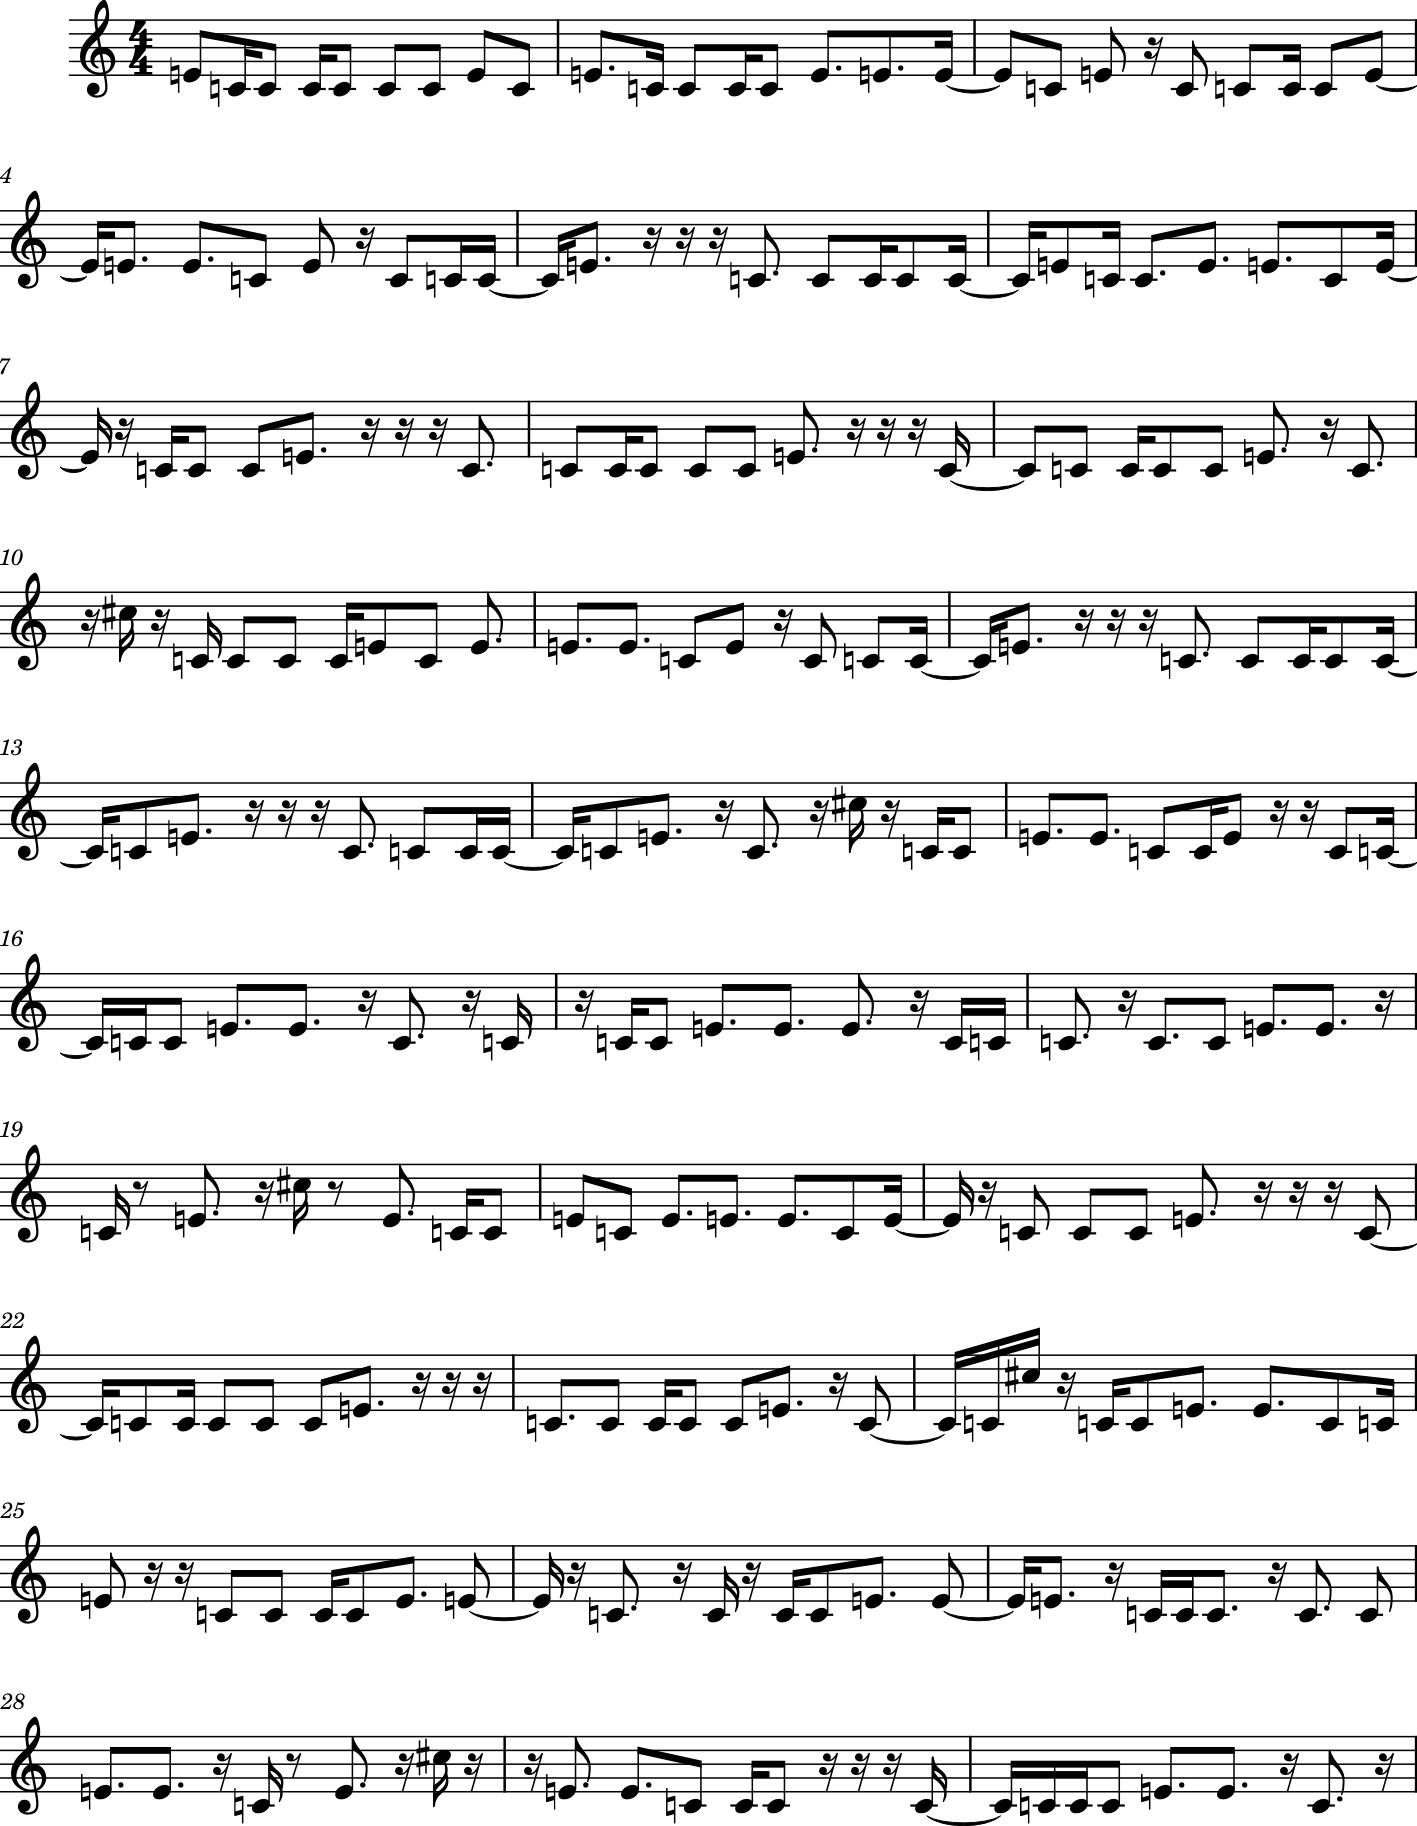

In [187]:
mus.show()

In [188]:
mus.show("midi")